# A/B Testing with Bayesian Analysis : Identifying products with more potentials

### Explore Dataset and determine priors

Let us first see the dataset

In [1]:
import pandas as pd
ads = pd.read_csv("dataset/ads.csv")
ads.head()

,user_id,product,site_version,time,banner_clicked
0,f500b9f27ac611426935de6f7a52b71f,clothes,desktop,2019-01-28 16:47:08,0
1,cb4347c030a063c63a555a354984562f,sneakers,mobile,2019-03-31 17:34:59,0
2,89cec38a654319548af585f4c1c76b51,clothes,mobile,2019-02-06 09:22:50,0
3,1d4ea406d45686bdbb49476576a1a985,sneakers,mobile,2019-05-23 08:07:07,0
4,d14b9468a1f9a405fa801a64920367fe,clothes,mobile,2019-01-28 08:16:37,0


We will create a helper function that will take a list of simulation as trials and some priors and then use these informations to generate posteriors. This is nothing but a beta distribution. We will be using beta distribution because it is a good choice for bayesian analysis due to:
- The Beta distribution is the conjugate prior for the Binomial distribution : if we start with a Beta prior and update it with Binomial data (`banner_clicked`), the posterior distribution is also a Beta distribution.
- Bounded support Limited to [0, 1]: Good way to show distribution of probability for a variable
- Variety of Shapes: we can change the shape of the distribution by the two parameters α and 𝛽. This flexibility allows it to represent a wide range of prior beliefs about the probability.

In [2]:
import numpy as np
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    num_successes = np.sum(trials)
    return np.random.beta(num_successes + beta_prior_a, len(trials) - num_successes + beta_prior_b, 10000)

A company has just run two pilot advertising campaigns: one for sneakers, and one for clothes. Our job is to find out which one was more effective as measured by the click-through rate and should be rolled out to a larger audience.

We have decided to run A/B testing, modeling the data using the binomial likelihood. We found out that a typical click-through rate for the previous ads has been around 15% recently, with results varying between 5% and 30%. Based on this, let us conclude that beta(10,50) would be a good prior for the click-through rate. Now we will generate prior draws with the helper function and visualize the distribution.

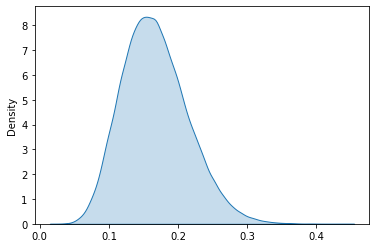

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# Generate prior draws
prior_draws = np.random.beta(10, 50, size=100000) 

# Plot the prior
sns.kdeplot(prior_draws, shade=True, label="prior")
plt.show()

### A or B : Which product is better?


We will now sort out the two products - clothes and sneakers into different dataframes.

In [4]:

# Extract the banner_clicked column for each product
clothes_clicked = ads.loc[ads["product"] == "clothes"]["banner_clicked"]
sneakers_clicked = ads.loc[ads["product"] == "sneakers"]["banner_clicked"]



Let us now simulate posterior draws with the helper function using the two product dataframes and visualize the distribution


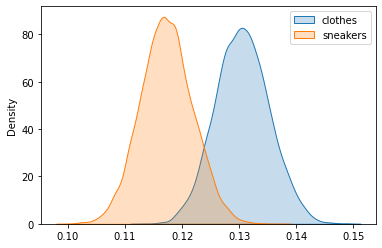

In [5]:

# Simulate posterior draws for each product
clothes_posterior = simulate_beta_posterior(clothes_clicked, 10, 50)
sneakers_posterior = simulate_beta_posterior(sneakers_clicked, 10, 50)
sns.kdeplot(clothes_posterior, shade=True, label="clothes")
sns.kdeplot(sneakers_posterior, shade=True, label="sneakers")
plt.legend()
plt.show()

We have discovered that clothes ads are likely to have a higher click ratio than sneakers ads. But we need to find out what is the exact probability that this. For that,  let us calculate the posterior difference between clothes and sneakers click rates and visualize the distribution.

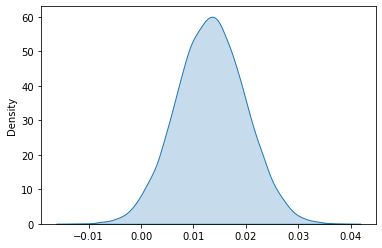

In [6]:
# Calculate posterior difference and plot it
diff = clothes_posterior - sneakers_posterior
sns.kdeplot(diff, shade=True, label="diff")
plt.show()

Now, we will calculate a credible interval for the difference to measure the uncertainty in the estimate. 


In [7]:
import arviz as az
# Calculate and print 90% credible interval of posterior difference
interval =  az.hdi(diff, hdi_prob=0.9)
print(interval)

[0.00268133 0.02428919]


Let us also visualize 90% credible interval of this distribution


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


<AxesSubplot:title={'center':'x'}>

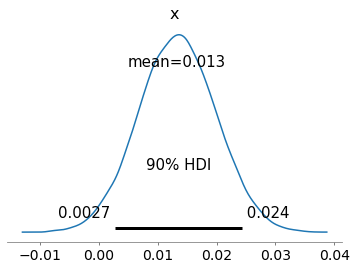

In [8]:
import pymc3 as pm
# Calculate and print 90% credible interval of posterior difference
# interval =  pm.plot_posterior(diff, hdi_prob=0.9)
pm.plot_posterior(diff, hdi_prob=0.9)
# print(interval)

Now, we will calculate the percentage of cases where this difference is positive, which corresponds to clothes click rate being higher. 

In [9]:

# Calculate and print probability of clothes ad being better
clothes_better_prob = (diff>0).mean()
print(clothes_better_prob)

0.9787


We have concluded that with 98% probability, clothes ads have a higher click-through ratio than sneakers ads. This suggests rolling out the clothes campaign to a larger audience. However, there is a 2% risk that it's the sneakers ads that are actually better. If that's the case, how many clicks do we lose if we roll out the clothes campaign?
The answer to this is the expected loss: the average posterior difference between the two click-through ratios given that sneakers ads do better. Let us also calculate it using the difference of distribution directly.

In [10]:
# Slice diff to take only cases where it is negative
loss = diff[diff < 0] # NOT (diff<0).mean()

# Compute and print expected loss
expected_loss = loss.mean()
print(expected_loss)

-0.002526076911162875
